# QuPath, QuBaLab & The QuPath Py4J Extension

## Overview

[**QuPath**](https://qupath.github.io) is interactive, user-friendly, open-source software for bioimage analysis and digital pathology. It's written in Java with JavaFX, and is scriptable using Groovy.

[**QuBaLab**](https://github.com/qupath/qubalab) is a Python package* that aims to support the same kinds of applications as QuPath, but in any entirely pythonic way. It doesn't try to replicate what QuPath does, nor does it try to replicate what other popular Python packages do, but rather help take care of some of the more mundane tasks that are common to many image analysis workflows... like figuring out how to read pixels and represent objects.

Although QuBaLab is entirely distinct from QuPath, it's designed by the same people - and intended to make it easy to switch between them.

The [**QuPath Py4J Extension**](https://github.com/qupath/qupath-extension-py4j) is a QuPath extension that helps bring the QuPath and QuBaLab worlds much closer together, thanks to [Py4J](https://www.py4j.org).

This notebook shows that in action.

> ### What problems does this solve?
> QuBaLab & the QuPath extension are intended to solve three main problems:
> 1. You mostly work with QuPath, but you need to do something that QuPath doesn't support. There are some useful Python libraries that could help, so you want a way to briefly dip into Python to get the job done.
> 2. You mostly work with Python, but you want to use QuPath for some things (e.g. annotating images, visualizing results). You want it to be as easy as possible to convert things from QuPath-friendly and Python-friendly formats.
> 3. You're a QuPath developer, and want to make it easy for people to get their data in and out. By co-developing QuBaLab, you're forced to think about interoperability from both sides... and also have a handy tool for prototyping new ideas.

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# For importing qubalab during development
lib_path = '../'
import sys
if not lib_path in sys.path:
    sys.path.append(lib_path)

import time
import matplotlib.pyplot as plt

## Getting started

To begin, you'll need to open QuPath and make sure that the *QuPath Py4J extension* is installed.

Installation basically involves dragging a jar file onto QuPath's main viewer, and then allowing QuPath to copy the jar to its extensions folder.

If that works, you should see a new Python icon in QuPath's toolbar, and also a command *Extensions &rarr; Py4J &rarr; Start Py4J Gateway*.

Both the toolbar button and menu command do the same thing - so click on either to open a *gateway* from QuPath to Python.

> For more info, see the [Py4J documentation](https://www.py4j.org)
> For more details about Py4J and security, see [this FAQ page](https://www.py4j.org/faq.html#are-there-any-security-concerns-with-py4j).

### Access the current image in QuPath

To make this interesting, you'll need to open a project and an image in QuPath, and add a few annotations to the image.

Next, we'll create a gateway on the Python side to access QuPath.

This provides an 'entry_point', which is a special Java class that gives us access to lots of things that will prove useful later. For now, we'll print a couple.

In [2]:
from qubalab.qubalab.qupath.py4j import *

# Using auto_convert makes things easier by converting Python collections to Java collections
gateway = create_gateway(auto_convert=True)
qp = gateway.entry_point

print(f'Main QuPath class: {qp.getQuPath()}')
print(f'Current image: {qp.getQuPath().getImageData()}')

Main QuPath class: qupath.lib.gui.QuPathGUI@300a5969
Current image: None


In [9]:
print(qp.getDetectionMeasurementTable(qp.getQuPath().getImageData()))

Image	Object ID	Object type	Name	Classification	Parent	ROI	Centroid X µm	Centroid Y µm	Nucleus: Area	Nucleus: Perimeter	Nucleus: Circularity	Nucleus: Max caliper	Nucleus: Min caliper	Nucleus: Eccentricity	Nucleus: Red mean	Nucleus: Red sum	Nucleus: Red std dev	Nucleus: Red max	Nucleus: Red min	Nucleus: Red range	Nucleus: Green mean	Nucleus: Green sum	Nucleus: Green std dev	Nucleus: Green max	Nucleus: Green min	Nucleus: Green range	Nucleus: Blue mean	Nucleus: Blue sum	Nucleus: Blue std dev	Nucleus: Blue max	Nucleus: Blue min	Nucleus: Blue range	Cell: Area	Cell: Perimeter	Cell: Circularity	Cell: Max caliper	Cell: Min caliper	Cell: Eccentricity	Cell: Red mean	Cell: Red std dev	Cell: Red max	Cell: Red min	Cell: Green mean	Cell: Green std dev	Cell: Green max	Cell: Green min	Cell: Blue mean	Cell: Blue std dev	Cell: Blue max	Cell: Blue min	Cytoplasm: Red mean	Cytoplasm: Red std dev	Cytoplasm: Red max	Cytoplasm: Red min	Cytoplasm: Green mean	Cytoplasm: Green std dev	Cytoplasm: Green max	Cytopl

### Create a QuPath snapshot

We can also create a snapshot to show that we're *really* connected to the current QuPath instance.

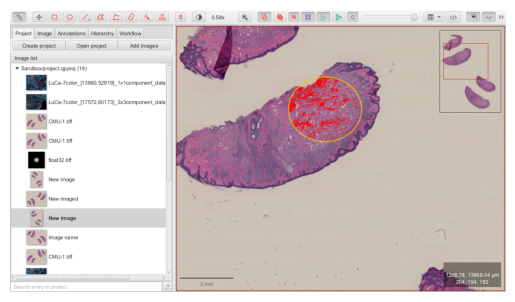

In [3]:
import matplotlib.image as mpimg
import base64
import io

def create_snapshot(snapshot_type):
    if (snapshot_type == 'qupath'):
        return qp.snapshotBase64(qp.getQuPath())
    else:
        return qp.snapshotBase64(qp.getCurrentViewer())

def show_snapshot(snapshot_type = 'qupath'):
    i = base64.b64decode(create_snapshot(snapshot_type=snapshot_type))
    i = io.BytesIO(i)
    i = mpimg.imread(i, format='png')

    plt.imshow(i)
    plt.axis(False)
    plt.show()

show_snapshot()

By default we get a snapshot of the entire user interface, but we can also restrict it to just the current viewer.

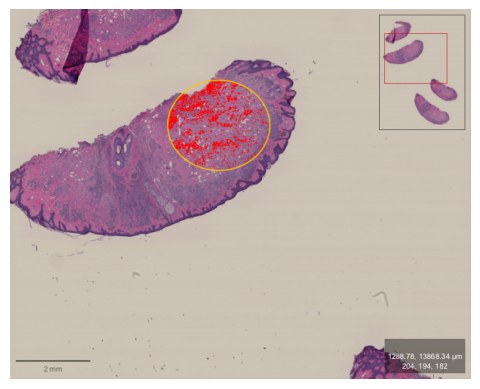

In [4]:
show_snapshot('viewer')

## Get objects from QuPath

Now let's request the annotation objects from QuPath.

We *could* do this by interacting with Java directly through the Gateway, but the `qubalab.qupath.py4j` module provides methods to make this much simpler. We've already imported them above, so we can just call `get_annotations()`

In [5]:
start_time = time.time_ns()
my_annotations = qp.getAnnotationObjects()
end_time = time.time_ns()
print(f'Retrieved {len(my_annotations)} object(s) in {(end_time - start_time) / 1e9} seconds')

Retrieved 1 object(s) in 0.001366 seconds


Let's now explore how an object is represented.

In [6]:
if len(my_annotations) > 0:
    print(my_annotations[0])
    print(type(my_annotations[0]))
    print(my_annotations[0].__dict__)
else:
    print('No annotations found - please draw at least one in QuPath, then repeat the previous cell')

Annotation (Other) (5757 objects)
<class 'py4j.java_gateway.JavaObject'>
{'_target_id': 'o36', '_gateway_client': <py4j.java_gateway.GatewayClient object at 0x12c3c4f80>, '_auto_field': False, '_methods': {}, '_field_names': set(), '_fully_populated': False, '_gateway_doc': None}


By default, we are given a way to access the Java objects (more or less) directly.

This is useful if we want to do something that isn't supported by the `qubalab.qupath.py4j` module, but it isn't very convenient... we end up needing to write Python code that looks a *lot* like Java code. We can also get stuck when things get complicated (e.g. due to threading issues) because we don't have the ability to do *everything* Java can do.

We *can* make changes though, like setting names and classifications, which is nice.

If we do, we should remember to call `refresh_qupath()` to update the interface accordingly.


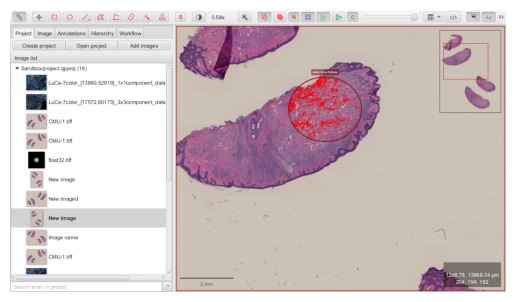

In [7]:
annotation = my_annotations[0]
annotation.setName("Hello from Python")
annotation.setClassifications(['Py4J'])
qp.getQuPath().getViewer().getHierarchy().resolveHierarchy()
show_snapshot()

### Get annotations as GeoJSON

There's another approach we can take.

Rather than directly accessing the QuPath objects, we can request them as GeoJSON.

This does *not* give direct access, but rather imports a more Python-friendly representation that is no longer connected to QuPath.

In [8]:
start_time = time.time_ns()
my_annotations = qp.toGeoJsonFeatureList(qp.getAnnotationObjects())
my_annotations = [geojson.loads(v) for v in my_annotations]
end_time = time.time_ns()
print(f'Retrieved {len(my_annotations)} object(s) in {(end_time - start_time) / 1e9} seconds')

Retrieved 1 object(s) in 0.004019 seconds


Now when we print our object, we should have a GeoJSON representation.

In [9]:
if len(my_annotations) > 0:
    print(my_annotations[0])
    print(type(my_annotations[0]))
else:
    print('No annotations found - please draw at least one in QuPath, then repeat the previous cell')

{"geometry": {"coordinates": [[[18013, 15255], [18006.97, 15424.47], [17988.9, 15593.27], [17958.87, 15760.74], [17916.99, 15926.21], [17863.43, 16089.04], [17798.4, 16248.57], [17722.15, 16404.18], [17634.99, 16555.25], [17537.27, 16701.2], [17429.36, 16841.43], [17311.69, 16975.41], [17184.73, 17102.59], [17048.98, 17222.49], [16904.97, 17334.62], [16753.27, 17438.54], [16594.49, 17533.84], [16429.24, 17620.15], [16258.18, 17697.13], [16081.99, 17764.47], [15901.36, 17821.9], [15717, 17869.21], [15529.64, 17906.19], [15340.02, 17932.72], [15148.89, 17948.67], [14957, 17954], [14765.11, 17948.67], [14573.98, 17932.72], [14384.36, 17906.19], [14197, 17869.21], [14012.64, 17821.9], [13832.01, 17764.47], [13655.82, 17697.13], [13484.76, 17620.15], [13319.51, 17533.84], [13160.73, 17438.54], [13009.03, 17334.62], [12865.02, 17222.49], [12729.27, 17102.59], [12602.31, 16975.41], [12484.64, 16841.43], [12376.73, 16701.2], [12279.01, 16555.25], [12191.85, 16404.18], [12115.6, 16248.57], [120

In practice, it's really a slightly 'enhanced' GeoJSON representation, because it includes a few extra fields that are relevant for QuPath.

This includes any classification, name, color and object type.
It also includes a plane, which stores `z` and `t` indices.

But because it is still basically GeoJSON, we can use it with other Python libraries that supports GeoJSON... such as `geojson`.

In [10]:
import geojson
print(geojson.dumps(my_annotations[0], indent=2))

{
  "type": "Feature",
  "id": "b23d6e95-ca13-4980-b29e-ef3f87db6c0a",
  "geometry": {
    "type": "Polygon",
    "isEllipse": true,
    "coordinates": [
      [
        [
          18013,
          15255
        ],
        [
          18006.97,
          15424.47
        ],
        [
          17988.9,
          15593.27
        ],
        [
          17958.87,
          15760.74
        ],
        [
          17916.99,
          15926.21
        ],
        [
          17863.43,
          16089.04
        ],
        [
          17798.4,
          16248.57
        ],
        [
          17722.15,
          16404.18
        ],
        [
          17634.99,
          16555.25
        ],
        [
          17537.27,
          16701.2
        ],
        [
          17429.36,
          16841.43
        ],
        [
          17311.69,
          16975.41
        ],
        [
          17184.73,
          17102.59
        ],
        [
          17048.98,
          17222.49
        ],
       

We can also use it with `Shapely`, which is particularly useful.

Shapely gives us access to lots of useful methods - and shapely objects can be displayed nicely in a Jupyter notebook.

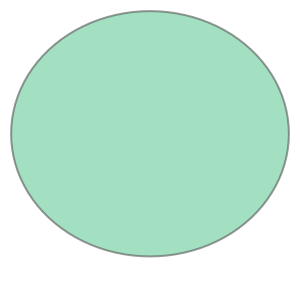

In [11]:
from shapely.geometry import shape
shape(my_annotations[0].geometry)

### Delete, add & modify annotations

The GeoJSON representation doesn't give us direct access to the QuPath objects, but we can still make changes and send them back.

The easiest way to see this in action is to begin by deleting the annotations...

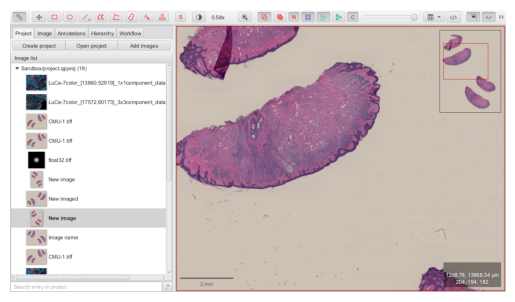

In [12]:
def delete_annotations():
    qp.getCurrentViewer().getHierarchy().removeObjects(qp.getAnnotationObjects(), False)

delete_annotations()
show_snapshot()

...and then adding them back again - but this time with a different color.

> We only assign colors to annotations that aren't classified, so that we don't override the colors that QuPath uses for classification.

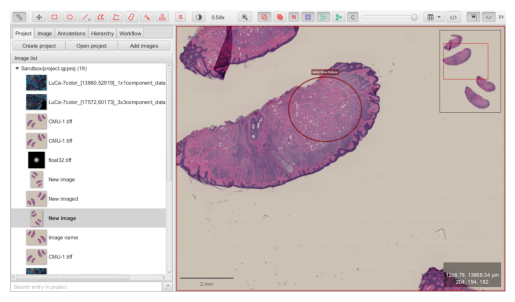

In [13]:
def add_objects(geoJsonObjects):
    for geoJson in geoJsonObjects:
        qp.addObject(qp.toPathObject(geojson.dumps(geoJson)))


for ann in my_annotations:
    import random
    if not ann.properties["classification"]:
        ann.color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

delete_annotations() # Delete again - in case we run this cell multiple times
add_objects(my_annotations)
show_snapshot()

### Create mask & labeled images

One reason to use Python rather than QuPath/Java is that NumPy/SciPy/scikit-image and other tools make working with pixels easier and more fun.

To begin, let's use the GeoJSON representation to create masks and labeled images.

In [14]:
from qubalab.qubalab.images.raster import *

bw = rasterize(my_annotations, downsample=20)
lab = rasterize(my_annotations, downsample=20, value=range(1, len(my_annotations)+1))

for ii, (im, title) in enumerate(zip([bw, lab], ['Binary', 'Labeled'])):
    plt.subplot(1, 2, ii+1)
    plt.imshow(im)
    plt.title(title)
    plt.axis(False)


ModuleNotFoundError: No module named 'qubalab.qubalab.images.raster'

## Image processing & creating objects

This whole thing becomes more useful when we start to use Python for image processing.

QuPath has the idea of an `ImageServer` that 'serves' pixels and metadata at any requested downsample (resolution), and QuBaLab supports that as well.

Here we'll use scikit-image to help find objects using two different thresholding methods.
We'll then convert them to QuPath objects and add them to the current QuPath viewer for visualization.

In [15]:
#from qubalab.images.raster import labels_to_features
from skimage.filters import gaussian, threshold_otsu, threshold_triangle
from skimage.color import rgb2gray

downsample = 40
qupath_server = qp.getQuPath().getImageData().getServer()
server = QuPathServer(gateway=gateway, server_obj=qupath_server)

im = server.read_region(downsample=downsample)
im_gray = rgb2gray(im)
im_gray = gaussian(im_gray, 2.0)

threshold_methods = {
    'Otsu' : threshold_otsu,
    'Triangle' : threshold_triangle
}


# delete_annotations()
# for ii, (name, method) in enumerate(threshold_methods.items()):
#     threshold = method(im_gray)
#     bw = im_gray < threshold
#     new_annotations = labels_to_features(bw.astype(np.uint8), downsample=downsample, classification=name, include_labels=True)
#     add_objects(new_annotations)

#     plt.subplot(1, len(threshold_methods), ii+1)
#     plt.imshow(bw)
#     plt.title(f'{name} (threshold={threshold:.2f})')
#     plt.axis(False)
# plt.show()

### Accessing pixels with Dask

`server.read_region()` is a very simple way to get pixels for a single image region, but it's not the only way - nor does it feel the most pythonic.

Using [Dask](https://docs.dask.org), we can get access to the entire image as a single, NumPy-like array, at any pyramid level - even if it's bigger than our RAM could handle.

The relevant parts are read lazily on demand.

In [16]:
from dask.cache import Cache
cache = Cache(2e9)  # Leverage two gigabytes of memory
cache.register()

im_small = server.to_dask(downsample=server.downsamples[-1])
display(im_small)

im_full = server.to_dask(downsample=server.downsamples[0])
display(im_full)

AttributeError: 'NoneType' object has no attribute 'shape'

We can use that to do some simple processing.

Here, we find the darkest pixel in the small image, and then extract the corresponding patch from the full image.

/var/folders/5f/l578vlrn29gd42rdsqbsv1380000gn/T/ipykernel_44784/4039444490.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  plt.plot(col, row, 'r*', ms=10, color='lime')


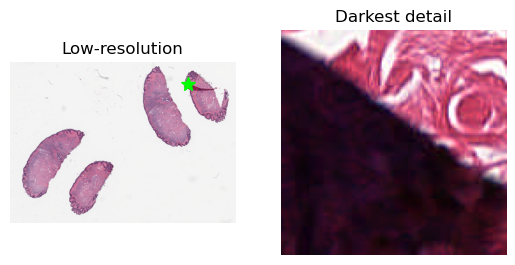

In [20]:
import numpy as np

im_small = im_small.squeeze()
im_full = im_full.squeeze()

darkest_index = im_small.mean(axis=-1).argmin()
row, col = np.unravel_index(darkest_index, im_small.shape[:2])
scale_row = im_full.shape[0] // im_small.shape[0]
scale_col = im_full.shape[1] // im_small.shape[1]

im_detail = im_full[...,
           int(row * scale_row - scale_row*4):int(row * scale_row + scale_row*4),
           int(col * scale_col - scale_col*4):int(col * scale_col + scale_col*4),
           :]


for ii, (im, title) in enumerate(zip([im_small, im_detail], ['Low-resolution', 'Darkest detail'])):
    plt.subplot(1, 2, ii+1)
    plt.imshow(im)
    if ii == 0:
        plt.plot(col, row, 'r*', ms=10, color='lime')
    plt.title(title)
    plt.axis(False)
plt.show()

### Viewing images in Napari

With the help of Dask, we can also use [Napari](https://napari.org) to view images - including multiresolution image pyramids.

That means we can stream the image from QuPath to Napari.
(It's not incredibly efficient... but it should work)

In [21]:
from qubalab.images import to_dask
import napari

# This uses some older code - we'd ideally use server.to_dask() instead,
# but here we get this in a more immediately Napari-friendly form
napari.view_image(**to_dask(server, as_napari_kwargs=True))
napari.run()

We can also use Dask to do some lazy calculations on the image, and then view the results in Napari.

Here, I use dask to calculate the mean pixel value at the lowest image resolution.
Then I use that as a threshold, applied to all images, and view the results in Napari.

> We do need to pay a bit of attention to the arguments though, in case they need changed. Here, the image is no longer RGB because we've computed to grayscale by averaging the RGB channels.

In [ ]:
arguments = to_dask(server, as_napari_kwargs=True)
arguments['rgb'] = False
threshold = arguments['data'][-1].mean()
arguments['data'] = [d.mean(axis=-1) < threshold for d in arguments['data']]
napari.view_image(**arguments)

## Displaying objects

We don't *need* QuPath to visualize GeoJSON features.

QuBaLab also includes functionality for generating matplotlib plots that *look* a lot like QuPath plots... but that don't use QuPath.

**Before running the next notebook cell**, you should draw a few small annotations in QuPath and detect cells within them.

The plotting code will show the annotations and cells - randomly recoloring the cells, to demonstrate that they are distinct from QuPath's rendering.

Py4JJavaError: An error occurred while calling t.getImageBase64.
: java.lang.OutOfMemoryError: Java heap space
	at java.desktop/java.awt.image.DataBufferInt.<init>(DataBufferInt.java:75)
	at java.desktop/java.awt.image.Raster.createPackedRaster(Raster.java:539)
	at java.desktop/java.awt.image.DirectColorModel.createCompatibleWritableRaster(DirectColorModel.java:1032)
	at java.desktop/java.awt.image.BufferedImage.<init>(BufferedImage.java:324)
	at qupath.lib.images.servers.AbstractTileableImageServer.createDefaultRGBImage(AbstractTileableImageServer.java:260)
	at qupath.lib.images.servers.AbstractTileableImageServer.readRegion(AbstractTileableImageServer.java:302)
	at qupath.lib.images.servers.AbstractTileableImageServer.readRegion(AbstractTileableImageServer.java:60)
	at qupath.ext.py4j.QuPathEntryPoint.getImageBytes(QuPathEntryPoint.java:321)
	at qupath.ext.py4j.QuPathEntryPoint.getImageBase64(QuPathEntryPoint.java:313)
	at jdk.internal.reflect.GeneratedMethodAccessor10.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:833)


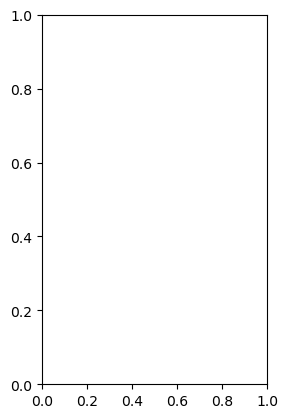

In [22]:
from qubalab.display.plots import show_image

annotations = get_annotations(converter='geojson')
detections = get_detections(converter='geojson')

for d in detections:
    d.color = [random.randint(0, 255) for _ in range(3)]

for annotation in annotations:
    ax = plt.subplot(1, 2, 1)

    show_image(server, region=annotation, downsample=2, ax=ax)
    plt.axis(False)
    ax = plt.subplot(1, 2, 2)
    show_image(server, image_objects=annotations, region=annotation, downsample=2, ax=ax, fill_opacity=0.1)
    show_image(image_objects=detections, region=annotation, downsample=2, ax=ax, fill_opacity=0.25)
    plt.axis(False)
    plt.show()

# print(len(annotation))
# show_image()

In [ ]:
qp.getCurrentViewer().getOverlayOptions().setShowAnnotations(False)

## Future things to do

* ~Threshold for detection~
* Plot objects with matplotlib
* Show/hide objects
* List images in project
* Open image in project
* 'Run for project'
* Set image type
* Show measurement table (pandas)
* Cluster objects (using ID)
* Add an image overlay
* Open in ImageJ?

In [ ]:
from geojson import Feature

class Anything(object):

    # def __repr__(self):
    #     return geojson.dumps(self, sort_keys=True)
    #
    # __str__ = __repr__
    #
    # def __getattr__(self, name):
    #     try:
    #         return self[name]
    #     except KeyError:
    #         raise AttributeError(name)
    #
    # def __setattr__(self, name, value):
    #     self[name] = value
    #
    # def __delattr__(self, name):
    #     del self[name]


class AnythingElse(object):

    def __init__(self, name):
        self._name = name

    @property
    def name(self):
        return self._name

    @name.setter
    def name(self, value):
        self._name = value

print('Starting')
hi = AnythingElse('hi')
print(hi.name)
hi.name = 'bye'
print(hi.name)
print('Done')

In [ ]:
from geojson import Feature

class AnythingElse(Feature):

    def __init__(self, name):
        super().__init__()
        self.properties['name'] = name

    @property
    def name(self):
        return self.properties['name']

    @name.setter
    def name(self, value):
        self.properties['name'] = value

# print('Starting')
# hi = AnythingElse('hi')
# print(hi.name)
# hi.name = 'bye'
# print(hi.name)
# print('Done2')

feature = AnythingElse('example')
feature.name = 'new name'
print(feature.name)

In [ ]:
from qubalab.objects import ImageObject

obj = ImageObject(geometry=None, name='there')
print(obj.name)
obj.name = 'hi'
print(obj.name)

